# Hit Point Calculation using Convex Hull Intersections

Small self-contained toy example for calculating hits between bounding boxes and LiDAR rays.

In [453]:
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

Let's look at a demo example of an intersection between a ray and the bounding boxes.

We need to derive the calculation:

We are looking for a $x$ that satisfies our linear inequality

$Ax + b\leq 0$

the $x$ is calculated as a ray $r$ from the unit circle with a scaling factor $\alpha$

$A \alpha r\leq -b$

We are looking for $alpha$ so this inequality is satisfied for all constraints. Reformulating equations leads to

$\hat{\alpha} \leq \frac{-b}{Ar}$

with $\frac{-b}{Ar}$ being a element-wise division. This results in a vector $\hat{\alpha}$ and we are interested in the entry $\alpha^\star$ that satisfies all conditions.



[0.875 7.   ]


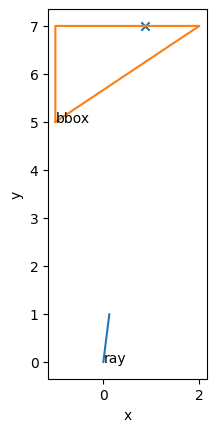

In [679]:
bb = np.array([[-1,5],
               [-1,7],
               [2,7],
               [-1,5],])
hull = ConvexHull(bb)
eq = hull.equations.T
A, b = eq[:-1].T, eq[-1]
ray = np.array([1.,8],dtype=float)
ray /= np.linalg.norm(ray)
alpha = np.divide(-b, (A @ ray.reshape(-1,1)).squeeze())
intersection_point = np.ones_like(ray) * np.inf
min_intersection_point_norm = np.inf
for a in alpha:
    intersection_candidate = ray * a
    intersection_candidate_norm = np.linalg.norm(intersection_candidate)
    if (A @ (intersection_candidate).squeeze() <= -b).all() and intersection_candidate_norm < min_intersection_point_norm:
        min_intersection_point_norm = intersection_candidate_norm
        intersection_point = intersection_candidate
print(intersection_point)
plt.plot([0, ray[0]], [0, ray[1]])
plt.text(0, 0, "ray")
plt.plot(bb[:,0], bb[:,1])
plt.text(bb[0,0], bb[0,1], "bbox")
plt.scatter(intersection_point[0], intersection_point[1], marker='x')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()

The ray ends up on the other side of the polygon. This is because of some numerical issues. We have to snap values, which are close to $-b$ so $A\alpha r\leq -b$ actually holds.

In [666]:
actual_intersection_point = (-ray * alpha[0]).squeeze()
print("actual intersection point", actual_intersection_point)
print("intersection point satisfied conditions", A @ actual_intersection_point <= -b)
print("left side inequality", A @ actual_intersection_point)
print("right side inequality", -b)

actual intersection point [0.77272727 6.18181818]
intersection point satisfied conditions [False  True  True]
left side inequality [-4.71495167 -0.77272727  6.18181818]
right side inequality [-4.71495167  1.          7.        ]


If we snap the values, to each other, that are really close, we fix this issue.

In [667]:
def snap_close_values(vec1, vec2, epsilon=1e-6):
    close_idx = np.linalg.norm(vec1.reshape(1,-1) - vec2.reshape(1,-1), axis=0) < epsilon
    vec1[close_idx] = vec2[close_idx]
    return vec1 

In [668]:
print("intersection point satisfied conditions (after snapping)", snap_close_values(A @ actual_intersection_point, -b) <= -b)

intersection point satisfied conditions (after snapping) [ True  True  True]


[0.77272727 6.18181818]


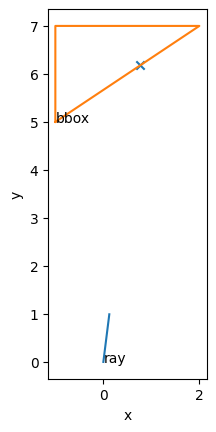

In [680]:
bb = np.array([[-1,5],
               [-1,7],
               [2,7],
               [-1,5],])
hull = ConvexHull(bb)
eq = hull.equations.T
A, b = eq[:-1].T, eq[-1]
ray = np.array([1.,8],dtype=float)
ray /= np.linalg.norm(ray)
alpha = np.divide(-b, (A @ ray.reshape(-1,1)).squeeze())
intersection_point = np.ones_like(ray) * np.inf
min_intersection_point_norm = np.inf
for a in alpha:
    intersection_candidate = ray * a
    intersection_candidate_norm = np.linalg.norm(intersection_candidate)
    if (snap_close_values(A @ intersection_candidate.squeeze(),-b) <= -b).all() and intersection_candidate_norm < min_intersection_point_norm:
        min_intersection_point_norm = intersection_candidate_norm
        intersection_point = intersection_candidate
print(intersection_point)
plt.plot([0, ray[0]], [0, ray[1]])
plt.text(0, 0, "ray")
plt.plot(bb[:,0], bb[:,1])
plt.text(bb[0,0], bb[0,1], "bbox")
plt.scatter(intersection_point[0], intersection_point[1], marker='x')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()

In [681]:
def calc_hit(ray: np.ndarray, convex_hull: ConvexHull):
    '''
        oriented and debugged implementation from reference: 
        https://stackoverflow.com/questions/30486312/intersection-of-nd-line-with-convex-hull-in-python

        input:
            - ray:
                np array of shape (dim, )
            - convex_hull_points:
                np array of shape (dim, N)
        output:
            - intersection_point:
                np array of shape (dim, )
    '''
    eq = convex_hull.equations.T
    A, b = eq[:-1].T, eq[-1]
    ray /= np.linalg.norm(ray)
    alpha = np.divide(-b, (A @ ray.reshape(-1,1)).squeeze())
    intersection_point = np.ones_like(ray) * np.inf
    intersection_point_norm = np.inf
    for a in alpha:
        intersection_candidate = ray * a
        intersection_candidate_norm = np.linalg.norm(intersection_candidate)
        if (snap_close_values(A @ intersection_candidate.squeeze(),-b) <= -b).all() and intersection_candidate_norm < intersection_point_norm:
            intersection_point_norm = intersection_candidate_norm
            intersection_point = intersection_candidate
    return intersection_point

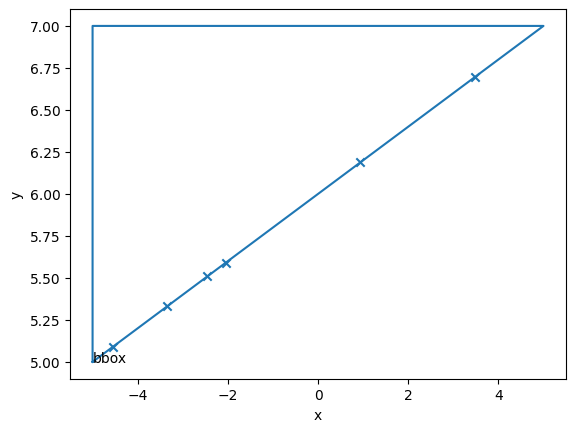

In [682]:
bb = np.array([[-5,5],
               [-5,7],
               [5,7],
               [-5,5]])
hull = ConvexHull(bb)

plt.plot(bb[:,0], bb[:,1])
plt.text(bb[0,0], bb[0,1], "bbox")

intersection_points = []
for i in range(20):
    ray = np.random.randn(2)
    intersection_points.append(calc_hit(ray, hull))
    
intersection_points = np.array(intersection_points)
plt.scatter(intersection_points[:,0], intersection_points[:,1], marker='x')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [683]:
def spherical2cartesian(radius, azimuth, elevation):
    '''
        Reference https://keisan.casio.com/exec/system/1359534351
    '''
    x = radius * np.sin(elevation) * np.cos(azimuth)
    y = radius * np.sin(elevation) * np.sin(azimuth)
    z = radius * np.cos(elevation)
    return np.stack([x,y,z]).T

In [684]:
def bbox_corners(bbox: dict):
    """
        Return : 3xn 
        Reference: https://github.com/yeyang1021/KITTI_VIZ_3D/blob/master/kitti_util.py
    """
    h   = bbox["h"] 
    w   = bbox["w"] 
    l   = bbox["l"] 
    x   = bbox["x"] 
    y   = bbox["y"] 
    z   = bbox["z"] 
    yaw = bbox["yaw"]
    R = Rotation.from_euler("z", yaw, degrees=False).as_matrix()
    corners = np.array([    [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2],
                            [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2],
                            [0,0,0,0,h,h,h,h]])
    corners = R @ corners
    corners += np.vstack([x, y, z])
    return corners

In [685]:
class LiDARSimulator():
    def __init__(self, num_layers, num_points_per_layer, fov=np.pi, tilt=-np.pi/8) -> None:
        self.num_layers = num_layers
        self.num_points_per_layer = num_points_per_layer
        self.fov = fov
        self.tilt = tilt
        
    def get_rays(self):
        azimuths = np.linspace(-np.pi, np.pi, self.num_points_per_layer)
        rays = np.zeros((0,3))
        for e in np.linspace(-np.pi + self.tilt, -np.pi + self.tilt + self.fov, self.num_layers):
            rays = np.concatenate([rays,spherical2cartesian(np.ones(len(azimuths)), azimuths, e*np.ones(len(azimuths)))])
        return rays

    def get_lidar_points(self, objects_in_scene: list):
        '''
            assume ray starts in (0,0,0)
        '''
        rays = self.get_rays()
        hits = list()
        for obj in objects_in_scene:
            bb_corners = bbox_corners(obj).T
            hull = ConvexHull(bb_corners)
            for ray in rays:
                hit = calc_hit(ray, hull)
                if not np.isinf(np.max(hit)):
                    hits.append(hit)
        hits_array = np.array(hits)
        return hits_array

Let's create the LiDAR simulator and look at the rays, that will be cast.

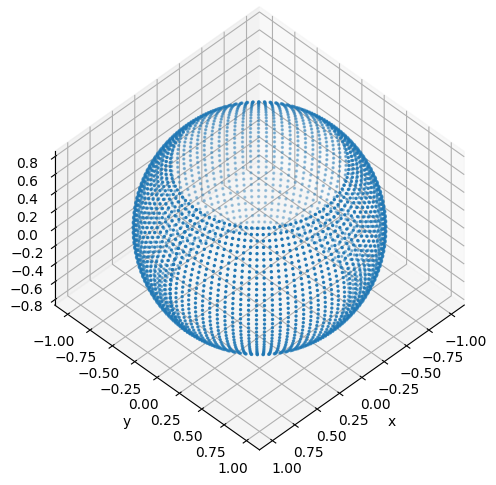

In [686]:
lidar_sim = LiDARSimulator(32, 100, fov=np.pi/2, tilt=np.pi/4)
rays = lidar_sim.get_rays()

ax = plt.axes(projection='3d')
ax.scatter3D(rays[:,0], rays[:,1], rays[:,2], s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

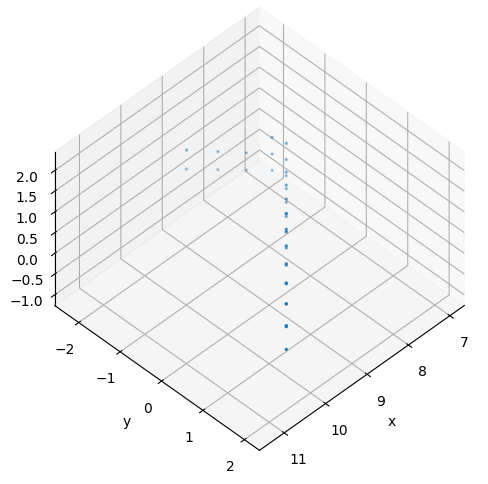

In [700]:
objects_in_scene = [{"h" : 1, "w" : 2, "l" : 5, "x" : 10, "y" : 0, "z" : 0, "yaw" : np.pi/4}]
points = lidar_sim.get_lidar_points(objects_in_scene)

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

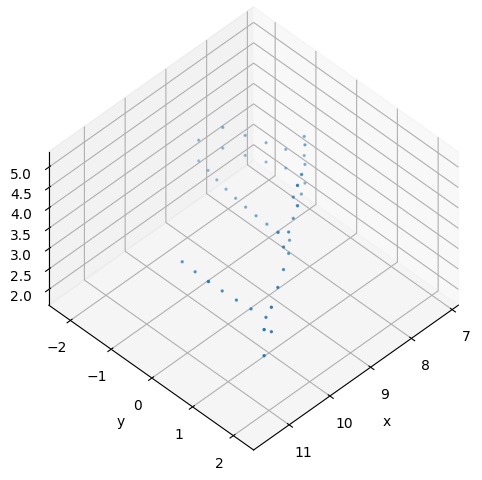

In [701]:
objects_in_scene = [{"h" : 1, "w" : 2, "l" : 5, "x" : 10, "y" : 0, "z" : 3, "yaw" : np.pi/5}]
points = lidar_sim.get_lidar_points(objects_in_scene)

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

In [702]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])